In [9]:
include("../../src/SPM.jl")
using Plots

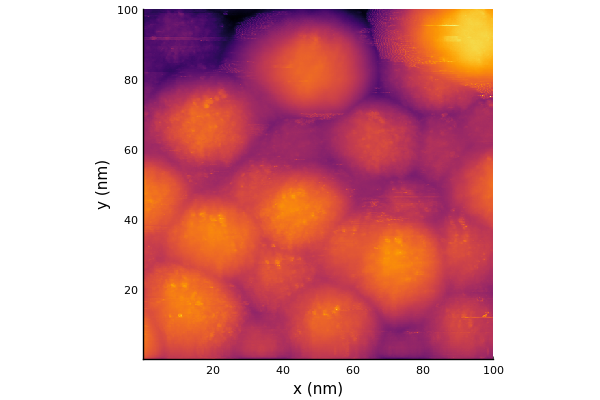

In [10]:
image = SPM.HDR.loadHDR("../data/B3446.hdr")
SPM.SPMCore.showHeatmap(image)

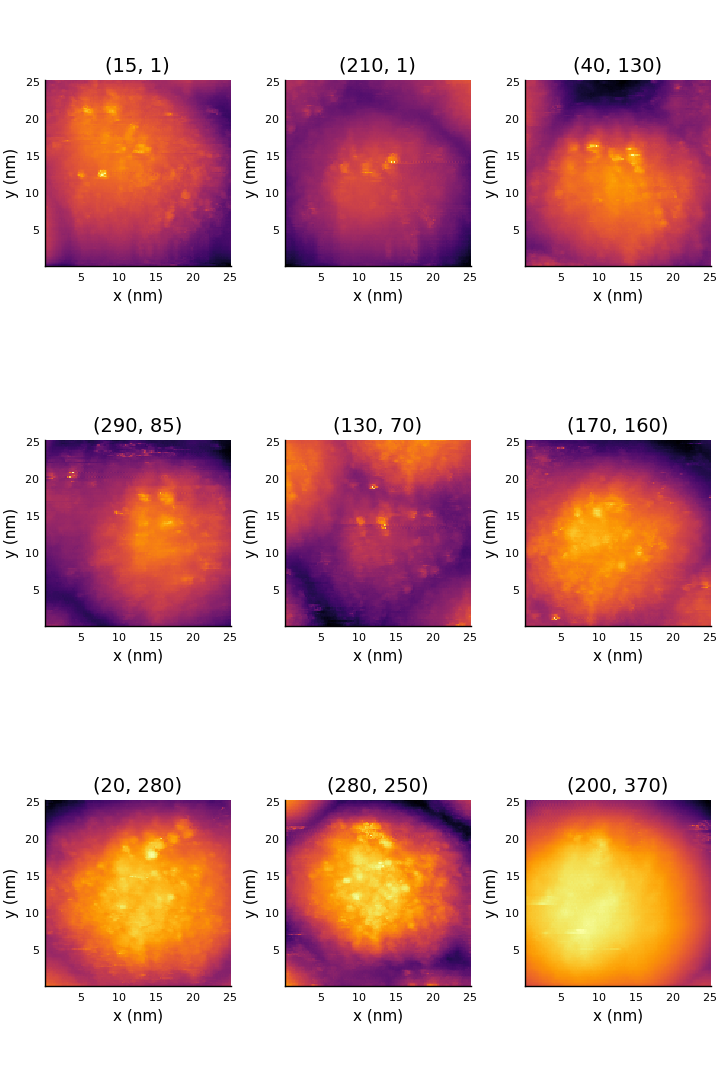

In [32]:
extract_size = (128,128)
plots = []
extracted_images = []
lowerlefts = [(15,1), (210,1), (40,130), (290,85), (130,70), (170, 160), (20, 280), (280, 250), (200, 370)]
for ll in lowerlefts
    push!(extracted_images, SPM.extract(image, ll, extract_size))
    push!(plots, SPM.showHeatmap(extracted_images[end]; title="$(ll)"))
end
    
plot(plots..., layout=(3,3), size=(720, 1080))